<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-Garethlomax/blob/master/mastersproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# test implementation of lstm, convlstm and cnn lstm in pytorch

# IMPORT - TORCH AND MOVING MNIST.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !ls

%cd /content/drive/My \Drive/masters_project/python_modules/MovingMNIST-master

# all torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms


import matplotlib.pyplot as plt

# importing moving mnist test set.
from MovingMNIST import MovingMNIST




/content/drive/My Drive/masters_project/python_modules/MovingMNIST-master


In [0]:
train_set = MovingMNIST(root='.data/mnist', train=True, download=True)


In [0]:
# len(train_set)
# of dimensions, sample, test data / predictordata, frame
train_set[0][2].shape


IndexError: ignored

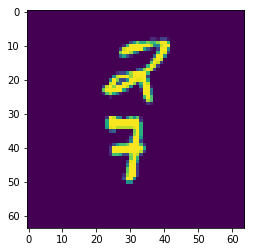

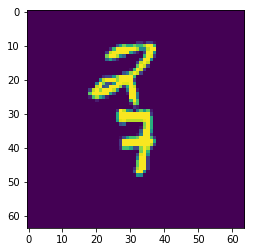

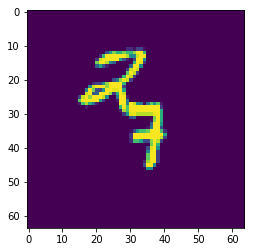

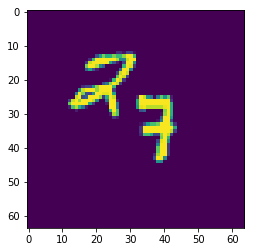

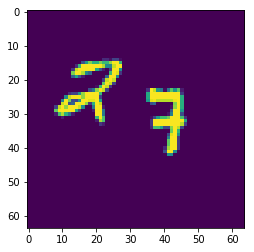

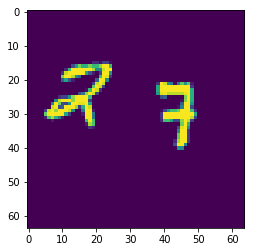

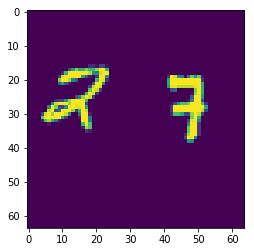

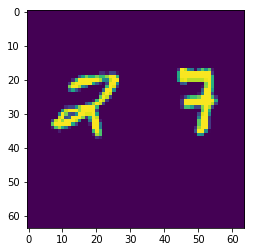

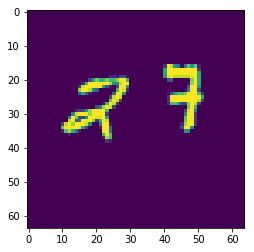

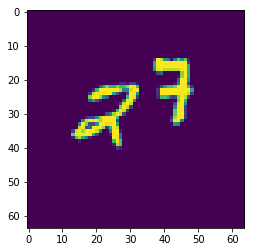

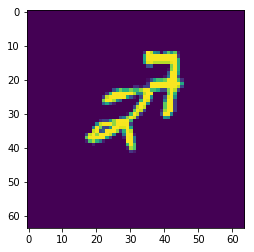

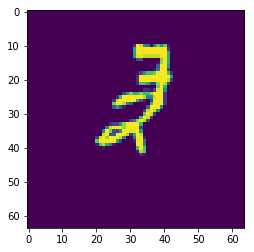

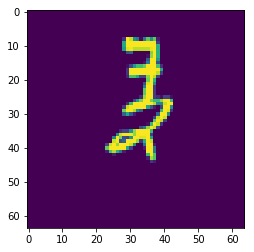

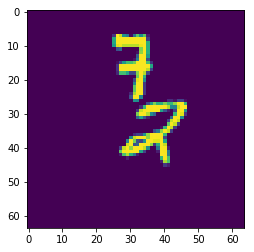

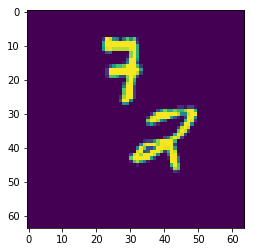

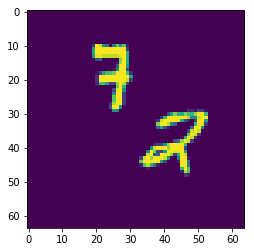

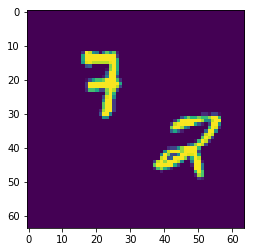

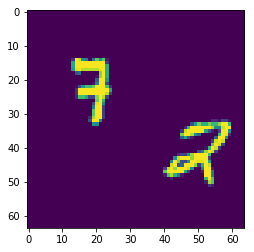

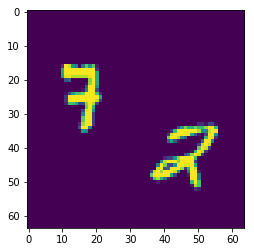

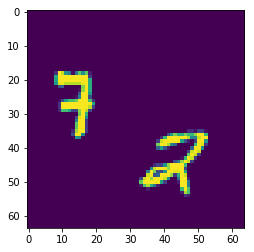

In [0]:
# examining video sequences.
for i in range(10):
    plt.figure()
    plt.imshow(train_set[0][0][i].numpy())

for i in range(10):
    plt.figure()
    plt.imshow(train_set[0][1][i].numpy())




# LSTM CELL AND MODEL

Based on lstm model from weather paper and others. 



In [0]:
# now we start lstm cell

"""TODO: CUDIFY EVERYTHING"""





class LSTMunit(nn.Module):
    def __init__(self, input_channel_no, hidden_channels_no, kernel_size):
        super(LSTMunit, self).__init__()
        """base unit for an overall convLSTM structure. convLSTM exists in keras but
        not pytorch. LSTMunit repersents one cell in an overall convLSTM encoder decoder format
        the structure of convLSTMs lend themselves well to compartmentalising the LSTM
        cells. 
    
        Each cell takes an input the data at the current timestep Xt, and a hidden
        representation from the previous timestep Ht-1
    
        Each cell outputs Ht
        """
    
    
        self.input_channels = input_channel_no
    
        self.output_channels = hidden_channels_no
    
        self.kernel_size = kernel_size
    
        self.padding = (self.kernel_size - 1) / 2 #to ensure output image same dims as input
        # as in conv nowcasting - see references 
        self.stride = 1 # for same reasons as above
        
        # need convolutions, cells, tanh, sigmoid?
        # need input size for the lstm - on size of layers.
        # cannot do this because of the modules not being registered when stored in a list
        # can if we convert it to a parameter dict
    
        # list of names of filter to put in dictionary.
        # some of these are not convolutions
        self.filter_name_list = ['Wxi','Whi','Wci', 'Wxf', 'Whf', 'Wcf', 'Wxc', 'Whc', 'Wxo', 'Who', 'Wco']
    
        """ TODO : DEAL WITH BIAS HERE. """ 
        """ TODO: CAN INCLUDE BIAS IN ONE OF THE CONVOLUTIONS BUT NOT ALL OF THEM - OR COULD INCLUDE IN ALL? """
    
        # list of concolution instances for each lstm cell step
        self.conv_list = [nn.Conv2D(self.input_channels, self.output_channels, self.kernel_size, self.padding, self.stride, self.bias) for i in range(len(self.filter_name_list))]
    
        # stores nicely in dictionary for compact readability.
        # most ML code is uncommented and utterly unreadable. Here we try to avoid this
        self.conv_dict = nn.ModuleDict(zip(self.filter_name_list, self.conv_list))
    
        # may be able to combine all the filters and combine all the things to be convolved - as long as there is no cross layer convolution
        # technically the filter will be the same? - check this later.
    
        # set up W_co, W_cf, W_co as variables.
        """ TODO: decide whether this should be put into function. """
        
        
        """TODO: put correct dimensions of tensor in shape"""
        
        self.Wco = torch.zeros(shape)
        self.Wcf = torch.zeros(shape)
        self.Wci = torch.zeros(shape)
    
    
    
        # activation functions.
        self.tanh = torch.tanh()
        self.sig  = torch.sigmoid()
    
    
    
    
    
    
#     (1, 6, kernel_size=5, padding=2, stride=1).double()
    def forward(self, x, h, c):
        """ put the various nets in here - instanciate the other convolutions."""
        
        """TODO: SORT BIAS OUT HERE"""
        """TODO: PUT THIS IN SELECTOR FUNCTION? SO ONLY PUT IN WXI ECT TO MAKE EASIER TO DEBUG?"""
        i_t = self.sig(self.conv_dict['Wxi'](x) + self.conv_dict['Whi'](h) + self.Wci * c)
        f_t = self.sig(self.conv_dict['Wxf'](x) + self.conv_dict['Whf'](h) + self.Wcf * c)
        c_t = f_t * c + i_t * self.tanh(self.conv_dict['Wxc'](x) + self.conv_dict['Whc'](h))
        o_t = self.sig(self.conv_dict['Wxo'](x) + self.conv_dict['Who'](h) + self.Wco * c_t)
        h_t = o_t * self.tanh(c_t)
        
        return h_t, c_t
    
    def copy_in(self):
        """dummy function to copy in the internals of the output in the various architectures i.e encoder decoder format"""

# LSTM FULL UNIT



In [0]:
class LSTMmain(nn.Module):
    
    
    """ collection of units to form encoder/ decoder branches - decide which are which
    need funcitonality to copy in and copy out outputs."""
    
    
    def __init__(self, shape, input_channel_no, hidden_channels_no, kernel_size):
        super(LSTMmain, self).__init__()
        """TODO: USE THIS AS BASIS FOR ENCODER DECODER."""
        """TODO: SPECIFY SHAPE OF INPUT VECTOR"""
        
        """TODO: FIGURE OUT HOW TO IMPLEMENT ENCODER DECODER ARCHITECUTRE"""
        
        self.shape = shape
        """specify dimensions of shape - as in channel length ect. figure out once put iit in a dataloader"""
        
        self.layers = 2 #number of layers in the encoder. 
        
        self.seq_length = shape[2]
        
        self.enc_len = len(shape)
        
        self.input_chans = input_channel_no
        
        self.hidden_chans = hidden_channel_no
        
        self.kernel_size = kernel_size
        
        # initialise the different conv cells. 
        self.unit_list = [LSTMunit(input_channel_no, hidden_channels_no, kernel_size) for i in range(enc_len)]
        self.unit_list = nn.ModuleList(self.unit_list)
        
        
        
        
        
        
        
        
    def forward(self, x):
        """loop over layers, then over hidden states"""
        
        
        """TODO: HOW MANY OUTPUTS TO SAVE"""
        """ S """
        
        """ TODO: PUT INITIAL ZERO THROUGH THE SYSTEM """
        
        
        for i in range(self.layers):
            # for each in layer
            for j in range(self.seq_length):
                # for each step in the sequence
                # put x through 
                ht1, ct1 = self.unit_list[i](x, h, c)
        
        
        
        
        
        
    def initialise(self):
        """put through zeros to start everything"""
        